# 인물 모드 문제점 찾기

In [2]:
import os
from os.path import join
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## Step 1. 인물모드 직접 해 보기

### (1) 함수 준비

In [3]:
def load_image(image_file): # 이미지 로드 함수
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'
    my_image_path = join(img_path, image_file)
    img_orig = cv2.imread(my_image_path)
    
    return img_orig, my_image_path

def show_image_rgb(image): # 이미지 rgb로 convert 후 표시하는 함수
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

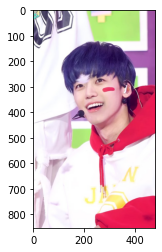

In [4]:
img_orig, my_image_path = load_image('jaemin5.jpeg') # 'jaemin5.jpeg' file load
show_image_rgb(img_orig) # show image

In [5]:
# load model
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fa08c2f1ee0>)

In [6]:
def image_segmentation(my_image_path): # model 로드 후 이미지 분석
    model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
    
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)
    segvalues, output = model.segmentAsPascalvoc(my_image_path)
    
    return segvalues, output

<function matplotlib.pyplot.show(close=None, block=None)>

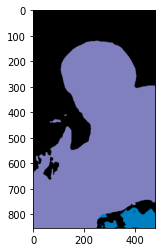

In [10]:
segvalues, output = image_segmentation(my_image_path)
plt.imshow(output)
plt.show

In [11]:
def show_feature(segvalues): # 인식되는 클래스 출력
    LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv']
    for class_id in segvalues['class_ids']:
        print(LABEL_NAMES[class_id])

In [12]:
show_feature(segvalues)

background
chair
diningtable
person
tv


In [13]:
def select_feature(label, output): # 원하는 이미지 선택
    labels = {'background':0, 'aeroplane':1, 'bicycle':2, 'bird':3, 'boat':4, 'bottle':5,
             'bus':6, 'car':7, 'cat':8, 'chair':9, 'cow':10, 'diningtable':11, 'dog':12, 'horse':13,
             'motorbike':14, 'person':15, 'pottedplant':16, 'sheep':16, 'sofa':17, 'train':18, 'tv':19}
    
    feature = labels[label]
    
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
        
    seg_color =((colormap[feature][2], colormap[feature][1], colormap[feature][0]))
    
    seg_map = np.all(output==seg_color, axis=-1) 

    return seg_map

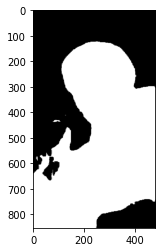

In [14]:
seg_map = select_feature('person', output)
plt.imshow(seg_map, cmap='gray')
plt.show()

In [36]:
def blur_image(img_orig, blur, seg_map): # 배경 블러
    img_orig_blur = cv2.blur(img_orig, blur)
    img_mask = seg_map.astype(np.uint8) * 255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    return img_bg_blur, img_mask_color

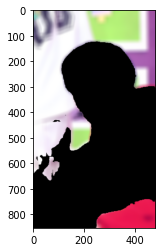

In [38]:
img_bg_blur, img_mask_color = blur_image(img_orig, (20,20), seg_map)
show_image_rgb(img_bg_blur)

In [17]:
def features(image_name): # 이미지 이름을 입력하면 인식되는 요소들 출력하는 함수
    _, my_image_path = load_image(image_name)
    segvalues, _ = image_segmentation(my_image_path)
    show_feature(segvalues)

In [39]:
def blur_back_image(image_name, feature, blur): # 이미지 이름, 선택할 요소, 블러 정도를 입력하면 배경이 블러처리된 이미지 출력
    img_orig, my_image_path = load_image(image_name)
    _, output = image_segmentation(my_image_path)
    seg_map = select_feature(feature, output)
    img_bg_blur, img_mask_color = blur_image(img_orig, blur, seg_map)
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    show_image_rgb(img_concat)

In [91]:
def change_back_image(image_name, background_name, feature): # 이미지 이름, 배경 이름, 선택 요소 입력하면 배경을 바꿈
    img_orig, my_image_path = load_image(image_name)
    image_shape = img_orig.shape
    _, output = image_segmentation(my_image_path)
    seg_map = select_feature(feature, output)
    img_change, _ = load_image(background_name)
    img_changed = cv2.resize(img_change, (image_shape[1], image_shape[0])) # 배경 이미지 사이즈를 원본 이미지와 같게 만들어줌
    img_mask = seg_map.astype(np.uint8)*255
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_concat = np.where(img_mask_color==255, img_orig, img_changed)
    
    show_image_rgb(img_concat)

### (2) 실행

In [19]:
features('jaemin5.jpeg')

background
chair
diningtable
person
tv


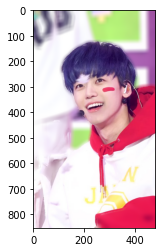

In [85]:
blur_back_image('jaemin5.jpeg', 'person', (20,20))

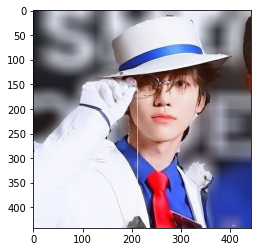

In [42]:
blur_back_image('jaemin6.jpeg', 'person', (40,40))

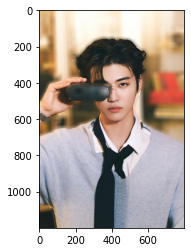

In [43]:
blur_back_image('jaemin7.jpeg', 'person', (30,30))

In [45]:
features('cat1.jpeg')

background
cat


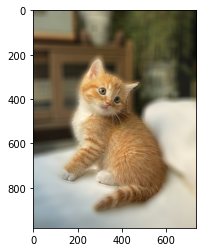

In [46]:
blur_back_image('cat1.jpeg', 'cat', (30,30)) # 선택 feature를 고양이로 입력, 고양이를 제외한 부분 blur

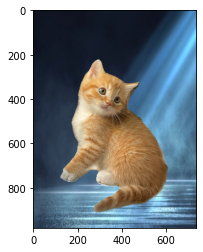

In [92]:
change_back_image('cat1.jpeg', 'background.jpeg', 'cat') # 고양이를 제외한 부분(배경) 이미지 바뀜

## Step 2. 사진에서 문제점 찾기

![img](https://github.com/rurube/Aiffel_Online5/assets/81694385/33d72339-50de-4bae-b99e-f8f158b8b43e)

팔 부분도 인물의 일부이지만 사람이 아닌 다른 것으로 인식된 것으로 보인다.

![img](https://github.com/rurube/Aiffel_Online5/assets/81694385/1a17f56e-629f-44df-9da1-215aa3de409f)
배경과 얼굴의 경계가 확실하게 인식되지 않아 얼굴 주변의 배경이 블러처리되지 않았다.
![img](https://github.com/rurube/Aiffel_Online5/assets/81694385/3d646f5b-57a9-4570-9903-82950d71e42f)
고양이 안쪽 배경이 배경으로 인식되지 않아 배경 사진으로 대체되지 않았다.

## Step 3. 해결 방법을 제안해 보기

   대체적으로 잘 인식했지만, 몇 가지 상황의 경우 인식이 잘 되지 않는 문제가 발생했고,
   - 타겟 feature와 근접한 배경이 흰 색일 때
   - 타겟 feature의 일부지만 색상의 차이가 크고 연결부가 명확하지 않을 때  
   
인식하는 데에 어려움을 겪는 것으로 추정했다.

 이러한 문제들은 2D 이미지를 3D처럼 바꿔주는 과정을 통해 보완될 수 있을 것 같다. 별도의 카메라나 센서를 사용하는 방법을 제외하고, depth 정보를 알 수 있게 해준다면 개선될 수 있을 것이다. 이를 위해서는 Monocular depth estimation, 단일 이미지의 depth를 예측해주는 모델을 사용할 수 있다. 이미지의 depth를 예측하는 모델 중, 코드가 공개되어 있고 설명 자료가 많은 **monodepth** 모델, 그 중에서도 **monodepth2** 모델을 알아보았다.  
 
 ![img](https://github.com/rurube/Aiffel_Online5/assets/81694385/45590eb4-60a5-4620-9087-92a075580c4c)  
 
 영상에 monodepth2를 적용한 모습이다. 이 모델은 기존 monodepth1에서 left, right 영상을 통해 학습한 것과 달리 연속된 이미지 ($I_{t-1}, I_t, I_{t+1})$을 이용하여 학습해 단일 이미지의 depth를 추정한다. 위 모델을 이용하여 이미지의 depth 정보를 input으로 추가해 준다면 output의 문제점을 어느 정도 해결할 수 있을 것으로 보인다.